## Performance analyse of PET with different values of D_PET and N_GNN

This notebook analyzes the performance of PET varing the values of such hyperparameters as `N_GNN` and `D_PET` (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) with the focus on evaluating the mean absolute error (MAE) and interference times.

In [407]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle

Helper functions

In [408]:
def sort_key(name):
    """
    Sorts folder names based on numeric values within the names
    """
    return [int(text) if text.isdigit() else text for text in re.split(r"(\d+)", name)]

In [409]:
def get_val_best_error(folders, keys):
    """
    Extract the value of best MAE/RMSE from the summary.txt
    """
    target_phrase_mae = "best val mae in energies per structure:"
    target_phrase_rmse = "best val rmse in energies per structure:"

    best_maes = {}
    best_rmse = {}

    for index, folder in enumerate(folders):
        path = os.path.join(folder, "results")
        attempts = sorted(os.listdir(path), key=sort_key)

        if not attempts:
            print(f"No result folders found in {path}")
            continue

        last_folder = attempts[-1]
        summary_file_path = os.path.join(path, last_folder, "summary.txt")

        if not os.path.isfile(summary_file_path):
            print(f"File {summary_file_path} not found")
            continue

        with open(summary_file_path, "r") as file:
            for line in file:
                if target_phrase_mae in line:
                    best_maes[str(keys[index])] = float(
                        line.split(target_phrase_mae)[-1].split()[0]
                    )

                if target_phrase_rmse in line:
                    best_rmse[str(keys[index])] = float(
                        line.split(target_phrase_rmse)[-1].split()[0]
                    )

    return best_maes, best_rmse

In [410]:
def get_best_error(folders, keys, rmse=False):
    """
    Extract the value of MAE / RMSE from the test.txt
    """
    target_phrase = "energies mae per atom : "
    if rmse:
        target_phrase = "energies rmse per atom : "
    best_maes = {}

    for index, folder in enumerate(folders):
        summary_file_path = os.path.join(folder, "test.txt")

        if not os.path.isfile(summary_file_path):
            print(f"File {summary_file_path} not found")
            continue

        with open(summary_file_path, "r") as file:
            for line in file:
                if target_phrase in line:
                    best_maes[str(keys[index])] = float(
                        line.split(target_phrase)[-1].split()[0]
                    )

    return best_maes

In [411]:
def plot_bars(x_values, y_values_list, labels, title, xlabel, ylabel):
    plt.figure(figsize=(16, 9))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    num_bars = len(x_values)
    bar_width = 0.8 / len(y_values_list)
    positions = np.arange(num_bars)
    colors = ["#FF8343", "#4158A6", "#179BAE"]

    for i, (y_values, label, color) in enumerate(zip(y_values_list, labels, colors)):
        plt.bar(
            positions + i * bar_width,
            y_values, 
            width=bar_width, 
            label=label, 
            color=color,
            align='center'
        )
        
        for pos, y in zip(positions + i * bar_width, y_values):
            plt.annotate(
                f"{y:.3f}", 
                (pos, y), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha="center",
                fontsize=14
            )
    plt.xticks(positions + bar_width * (len(y_values_list) / 2 - 0.5), x_values, fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=18, loc='lower left')
    plt.show()

In [412]:
N_GNNs = [1, 2, 3]
D_PET = [32, 64, 128]

In [413]:
folders_32 = ["run_1_32", "run_2_32", "run_3_32"]
folders_64 = ["run_1_64", "run_2_64", "run_3_64"]
folders_128 = ["run_1_128", "run_2_128", "run_3_128"]

folders_n1 = ["run_1_32", "run_1_64", "run_1_128"]
folders_n2 = ["run_2_32", "run_2_64", "run_2_128"]
folders_n3 = ["run_3_32", "run_3_64", "run_3_128"]

In [414]:
best_maes_32, best_rmse_32 = get_val_best_error(folders=folders_32, keys=N_GNNs)
best_maes_64, best_rmse_64 = get_val_best_error(folders=folders_64, keys=N_GNNs)
best_maes_128, best_rmse_128 = get_val_best_error(folders=folders_128, keys=N_GNNs)

In [415]:
best_maes_n1, best_rmse_n1 = get_val_best_error(folders=folders_n1, keys=D_PET)
best_maes_n2, best_rmse_n2 = get_val_best_error(folders=folders_n2, keys=D_PET)
best_maes_n3, best_rmse_n3 = get_val_best_error(folders=folders_n3, keys=D_PET)

### Best val MAE vs Number of GNN Layers

MAE is analysed against the number of GNN layers with a fixed dimensionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET

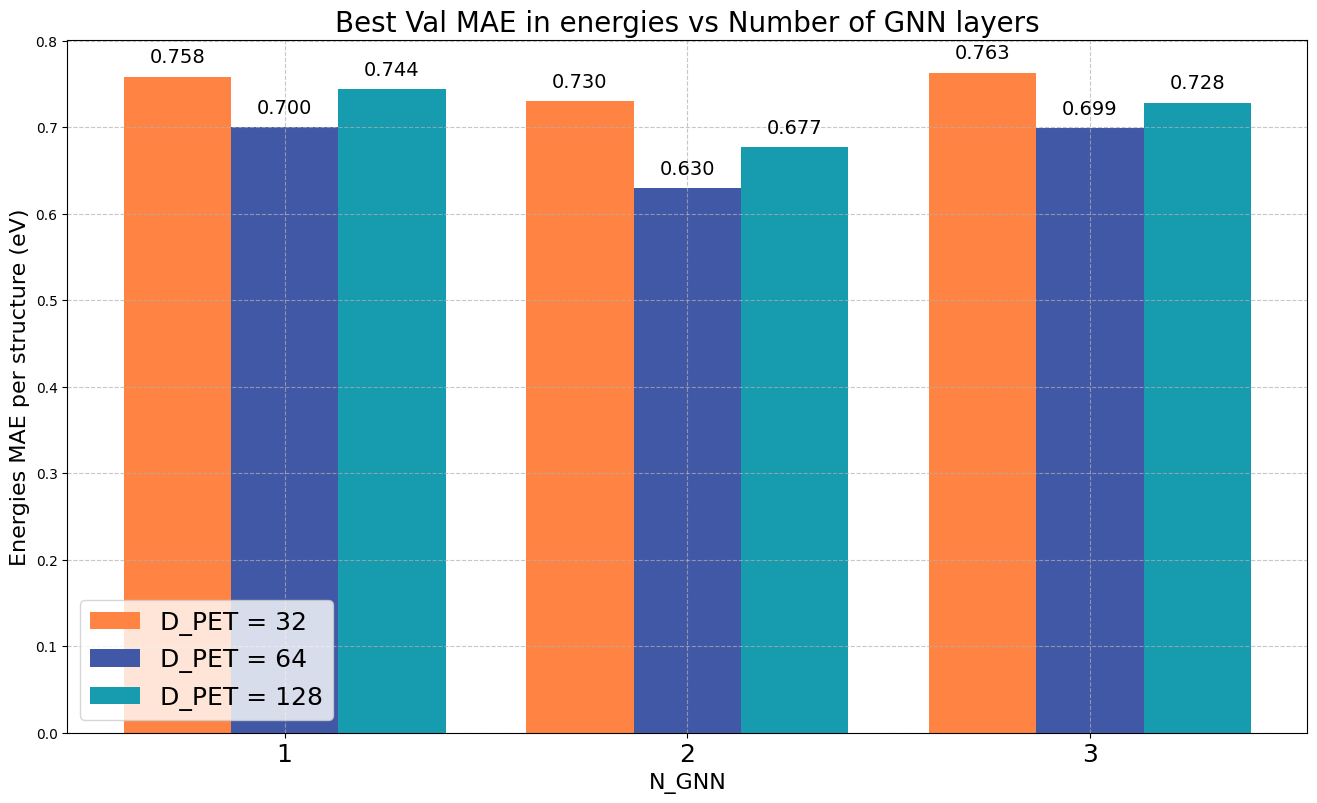

In [416]:
y_values_32 = list(best_maes_32.values())
y_values_64 = list(best_maes_64.values())
y_values_128 = list(best_maes_128.values())

plot_bars(
    N_GNNs,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Best Val MAE in energies vs Number of GNN layers",
    xlabel="N_GNN",
    ylabel="Energies MAE per structure (eV)",
)

### Best val MAE vs D_PET

MAE is analysed against the dimentionality (`HEAD_N_NEURONS`, `TRANSFORMER_D_MODEL`) of the PET with a fixed number of GNN layers

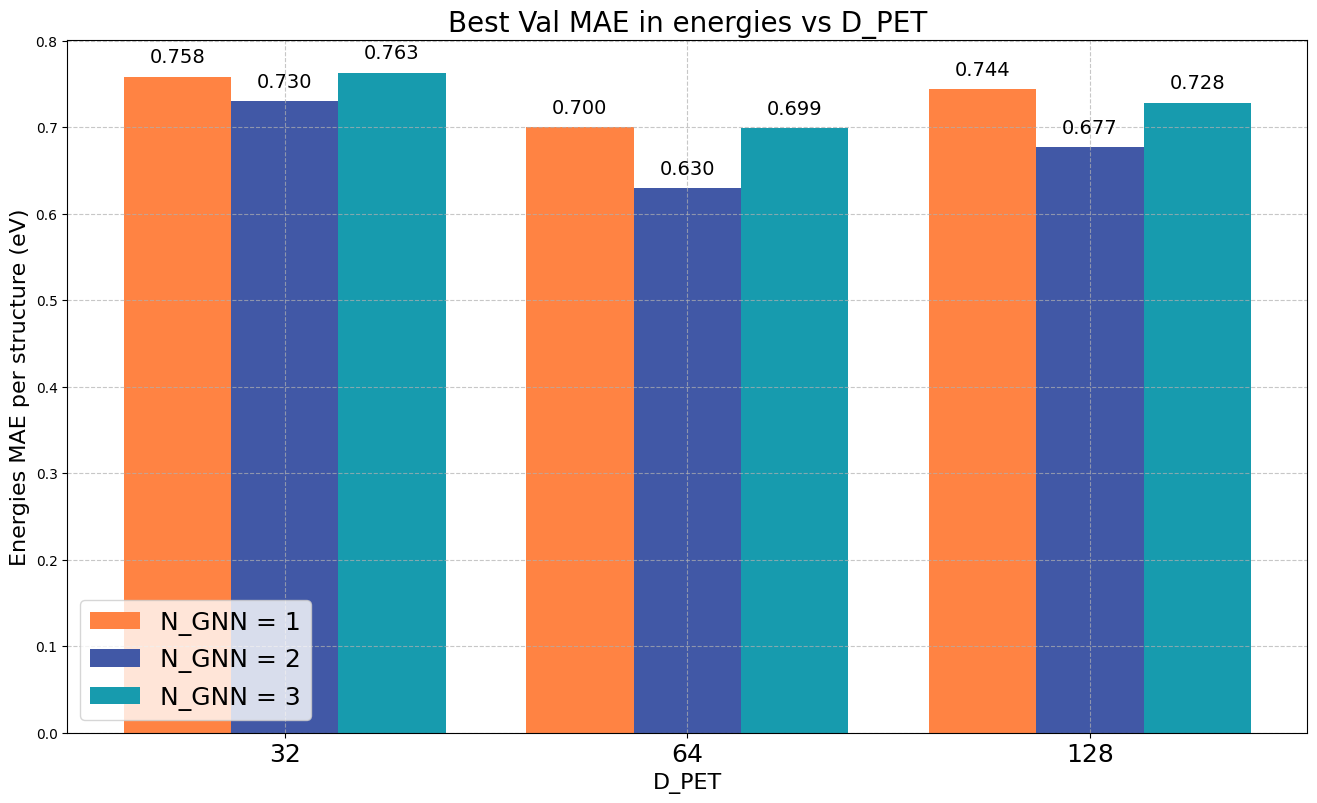

In [417]:
y_values_n1 = list(best_maes_n1.values())
y_values_n2 = list(best_maes_n2.values())
y_values_n3 = list(best_maes_n3.values())

plot_bars(
    D_PET,
    [y_values_n1, y_values_n2, y_values_n3],
    ['N_GNN = 1', 'N_GNN = 2', 'N_GNN = 3'],
    title="Best Val MAE in energies vs D_PET",
    xlabel="D_PET",
    ylabel="Energies MAE per structure (eV)",
)

### Best val RMSE vs Number of GNN Layers

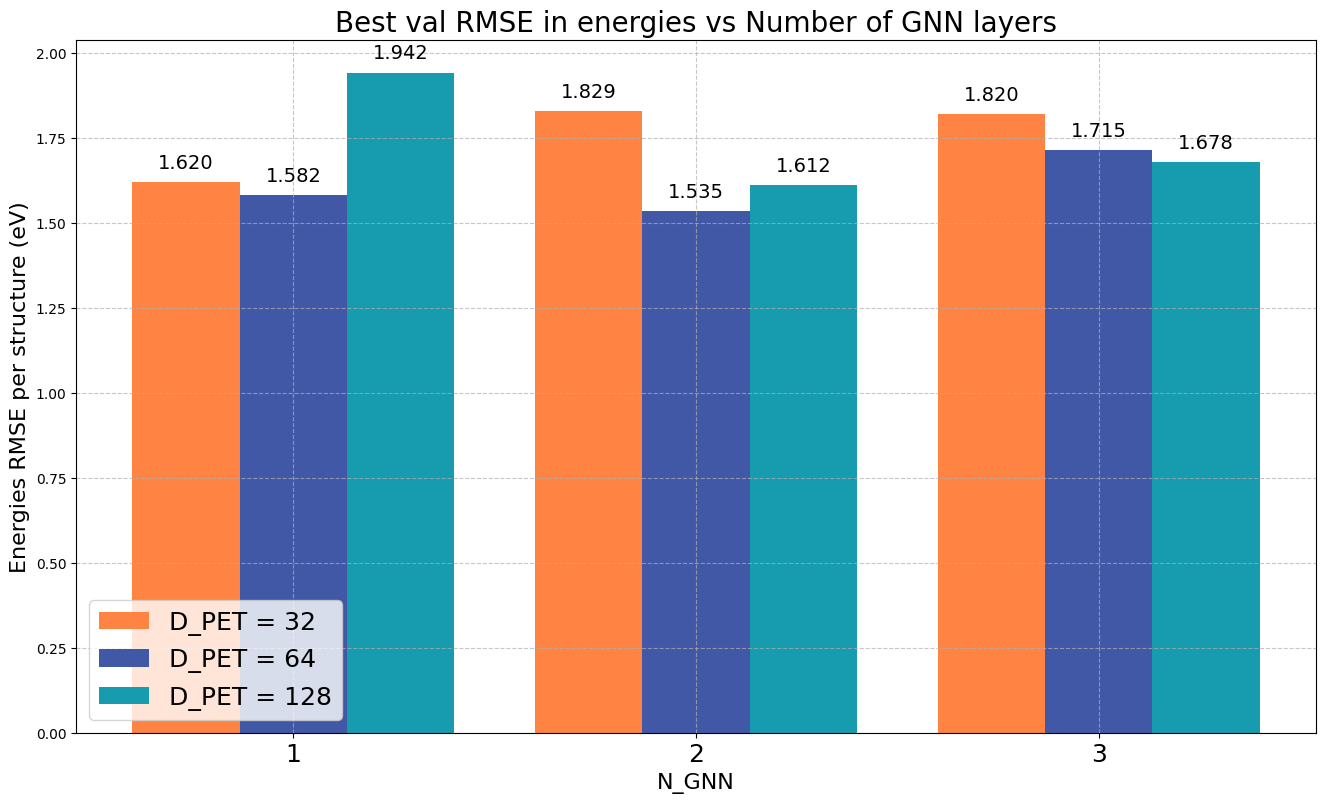

In [418]:
y_values_32 = list(best_rmse_32.values())
y_values_64 = list(best_rmse_64.values())
y_values_128 = list(best_rmse_128.values())

plot_bars(
    N_GNNs,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Best val RMSE in energies vs Number of GNN layers",
    xlabel="N_GNN",
    ylabel="Energies RMSE per structure (eV)",
)

### Best val RMSE vs D_PET

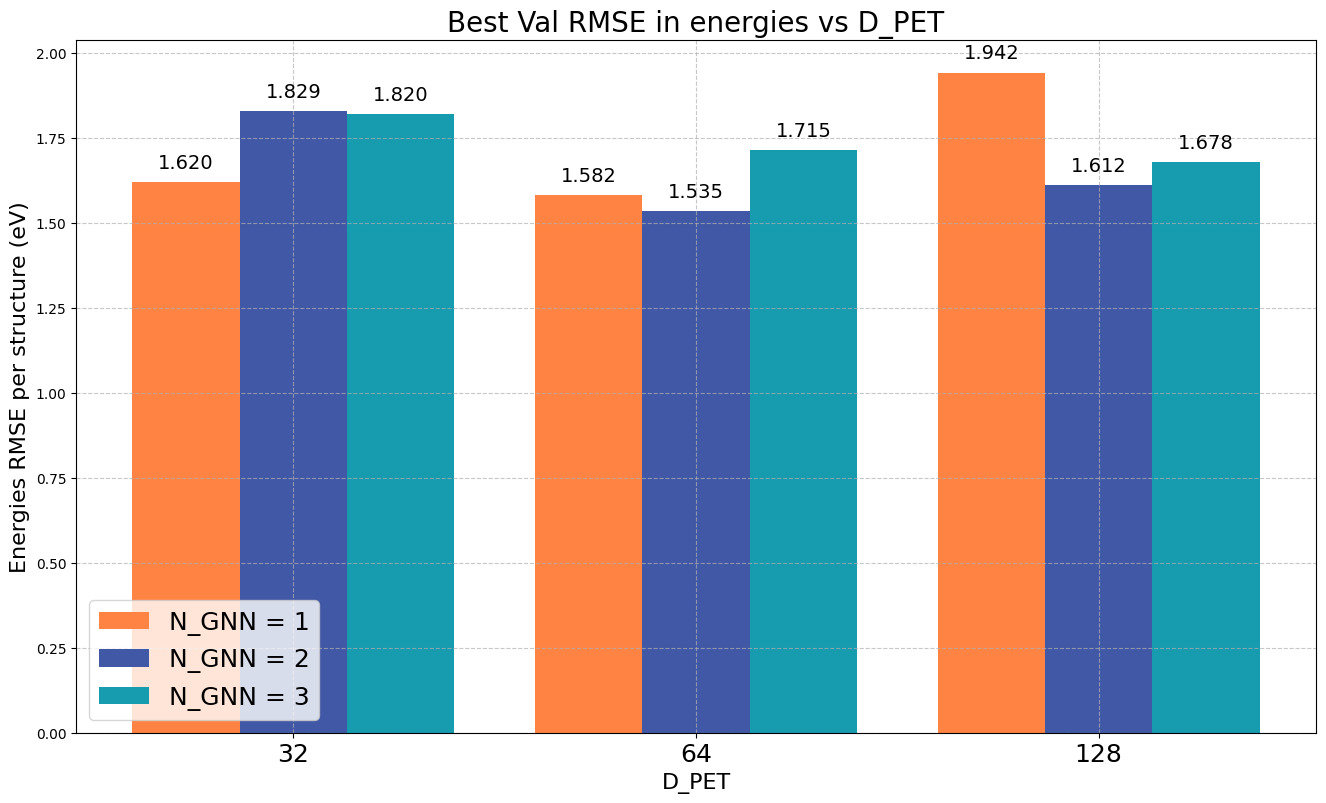

In [419]:
y_values_n1 = list(best_rmse_n1.values())
y_values_n2 = list(best_rmse_n2.values())
y_values_n3 = list(best_rmse_n3.values())

plot_bars(
    D_PET,
    [y_values_n1, y_values_n2, y_values_n3],
    ['N_GNN = 1', 'N_GNN = 2', 'N_GNN = 3'],
    title="Best Val RMSE in energies vs D_PET",
    xlabel="D_PET",
    ylabel="Energies RMSE per structure (eV)",
)

### Inference Times

Finally, we analyze the interference times from the output of running fitted PET models on the test structures. 

In [420]:
FOLDERS = ["run_1_32", "run_1_64", "run_1_128", "run_2_32", "run_2_64", "run_2_128", "run_3_32", "run_3_64", "run_3_128"]
KEYS = [
    "N_GNN 1, D_PET 32",
    "N_GNN 1, D_PET 64",
    "N_GNN 1, D_PET 128",
    "N_GNN 2, D_PET 32",
    "N_GNN 2, D_PET 64",
    "N_GNN 2, D_PET 128",
    "N_GNN 3, D_PET 32",
    "N_GNN 3, D_PET 64",
    "N_GNN 3, D_PET 128",
]

In [421]:
def get_test_error():
    target_phrase_time = "approximate time per atom"
    target_phrase_mae = "energies mae per atom"
    target_phrase_rmse = "energies rmse per atom"

    interference_times = {}
    mae = {}
    rmse = {}

    for index, folder in enumerate(FOLDERS):
        test_file_path = os.path.join(folder, "test.txt")

        if not os.path.isfile(test_file_path):
            print(f"File {test_file_path} not found")
            continue

        with open(test_file_path, "r") as file:
            for line in file:
                if target_phrase_mae in line:
                    mae[KEYS[index]] = float(line.split()[-1].strip())

                if target_phrase_rmse in line:
                    rmse[KEYS[index]] = float(line.split()[-1].strip())

                if target_phrase_time in line:
                    interference_times[KEYS[index]] = float(line.split()[-2].strip())
    
    return mae, rmse, interference_times


def plot(x_values, y_values, keys, rmse=False):
    error_type = "MAE"
    if rmse:
        error_type = "RMSE"

    plt.figure(figsize=(20, 14))
    plt.title(f"Energy {error_type} per Atom vs. Inference Time", fontsize=22)
    plt.xlabel("Inference Time (seconds)", fontsize=19)
    plt.ylabel(f"Energies {error_type} per Atom (meV/A)", fontsize=19)
    plt.scatter(y_values, x_values, color="#4158A6", s=700, edgecolor='black', alpha=0.7, label="PET configurations")

    for index, (y, x) in enumerate(zip(y_values, x_values)):
        plt.annotate(
            f"{keys[index]}",
            (y, x),
            textcoords="offset points",
            xytext=(0, 27),
            ha="center",
            fontsize=18,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
        )
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=24)
    plt.tight_layout()
    plt.show()

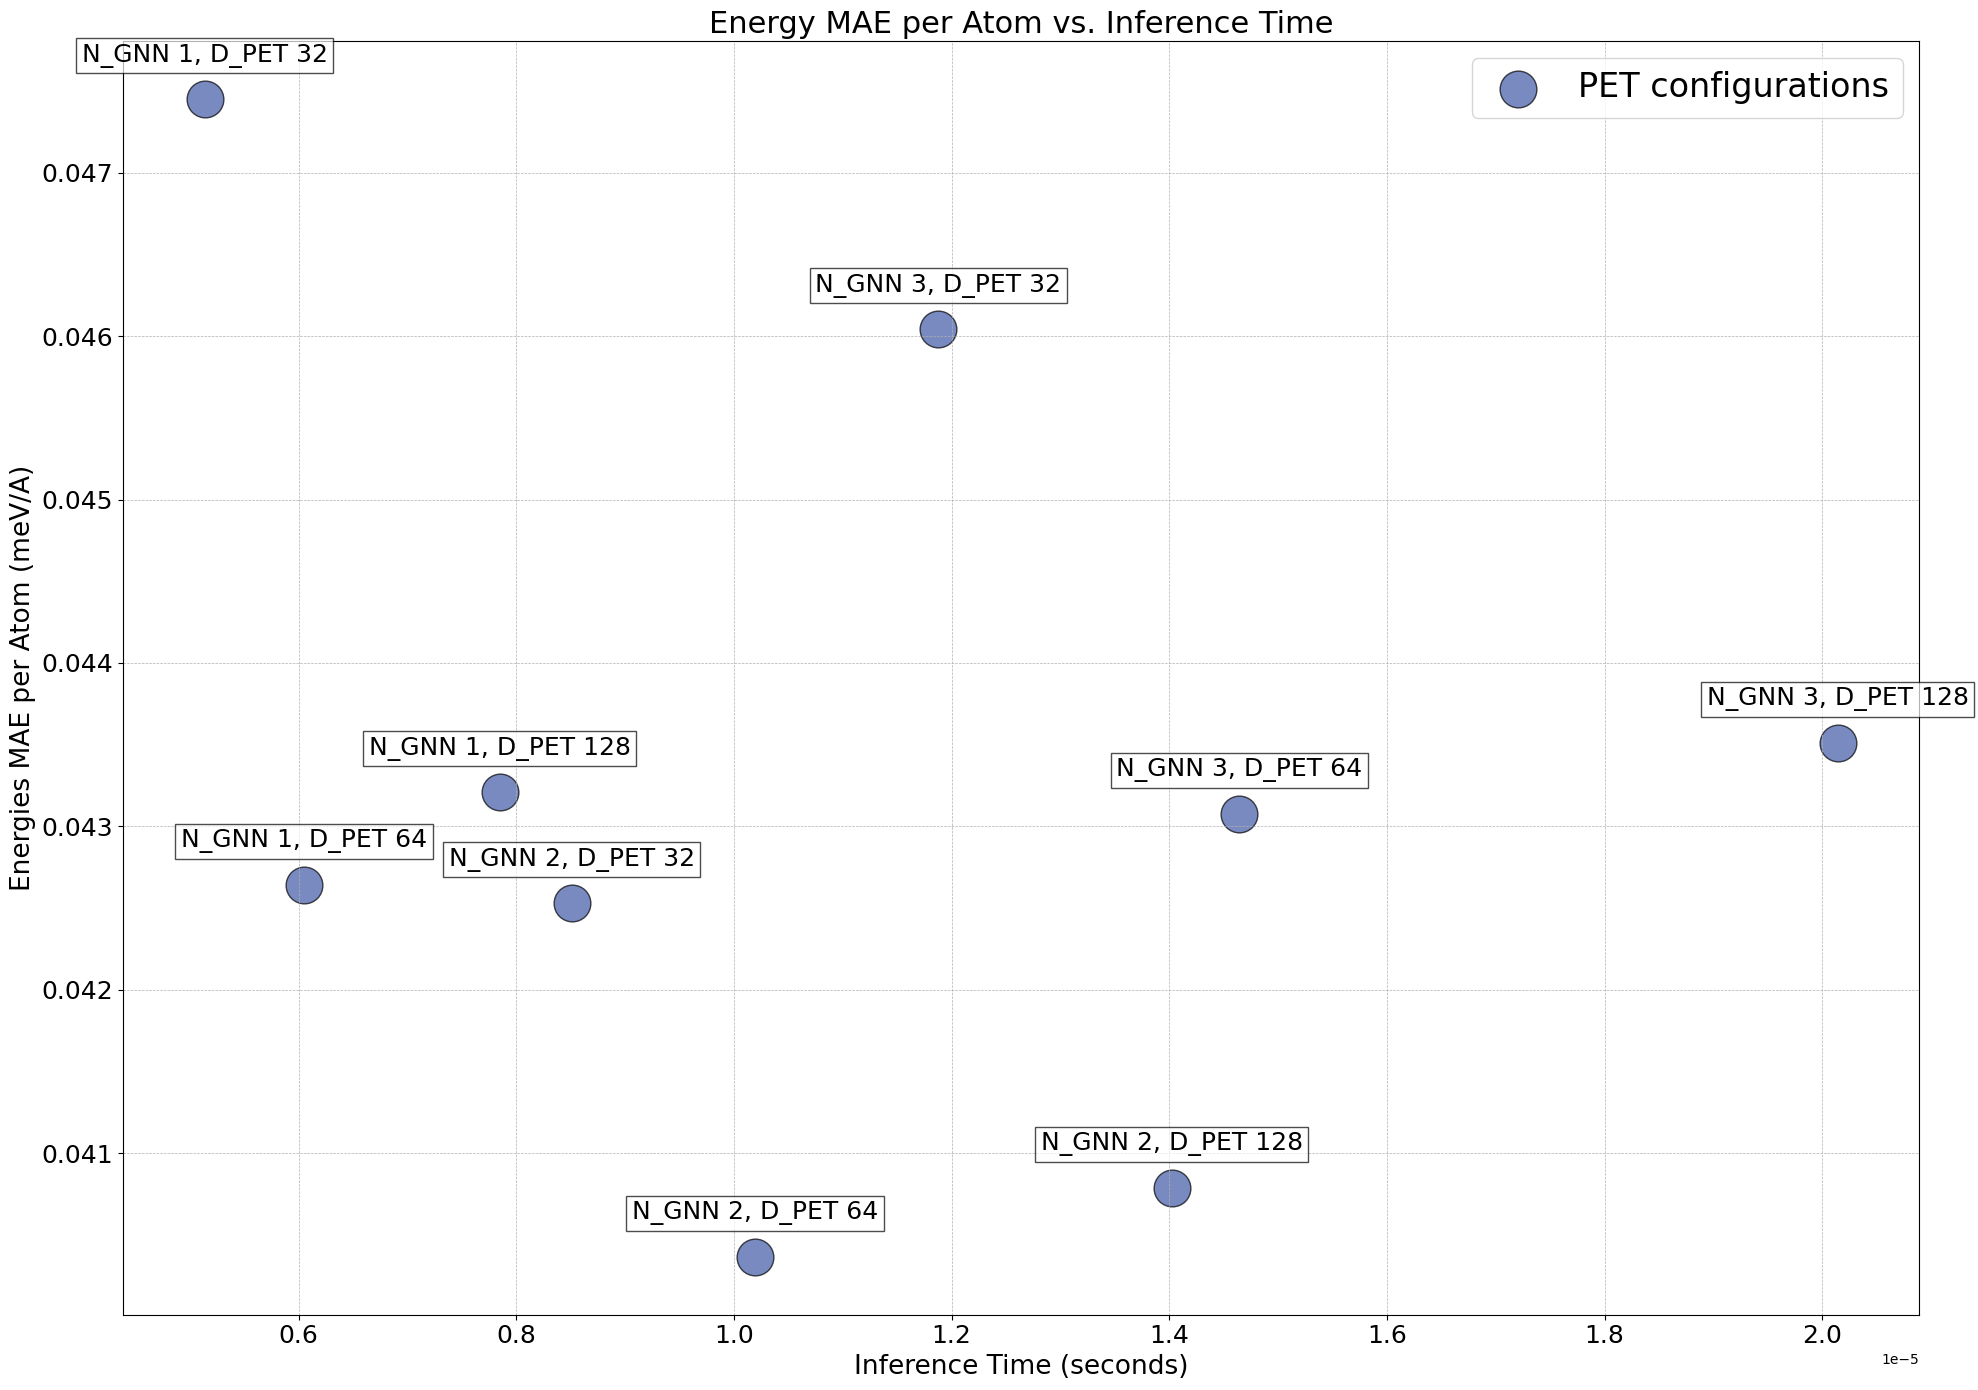

In [422]:
maes_test, rmse_test, interference_times = get_test_error()

x_values = list(maes_test.values())
y_values = list(interference_times.values())
plot(x_values, y_values, list(maes_test.keys()))

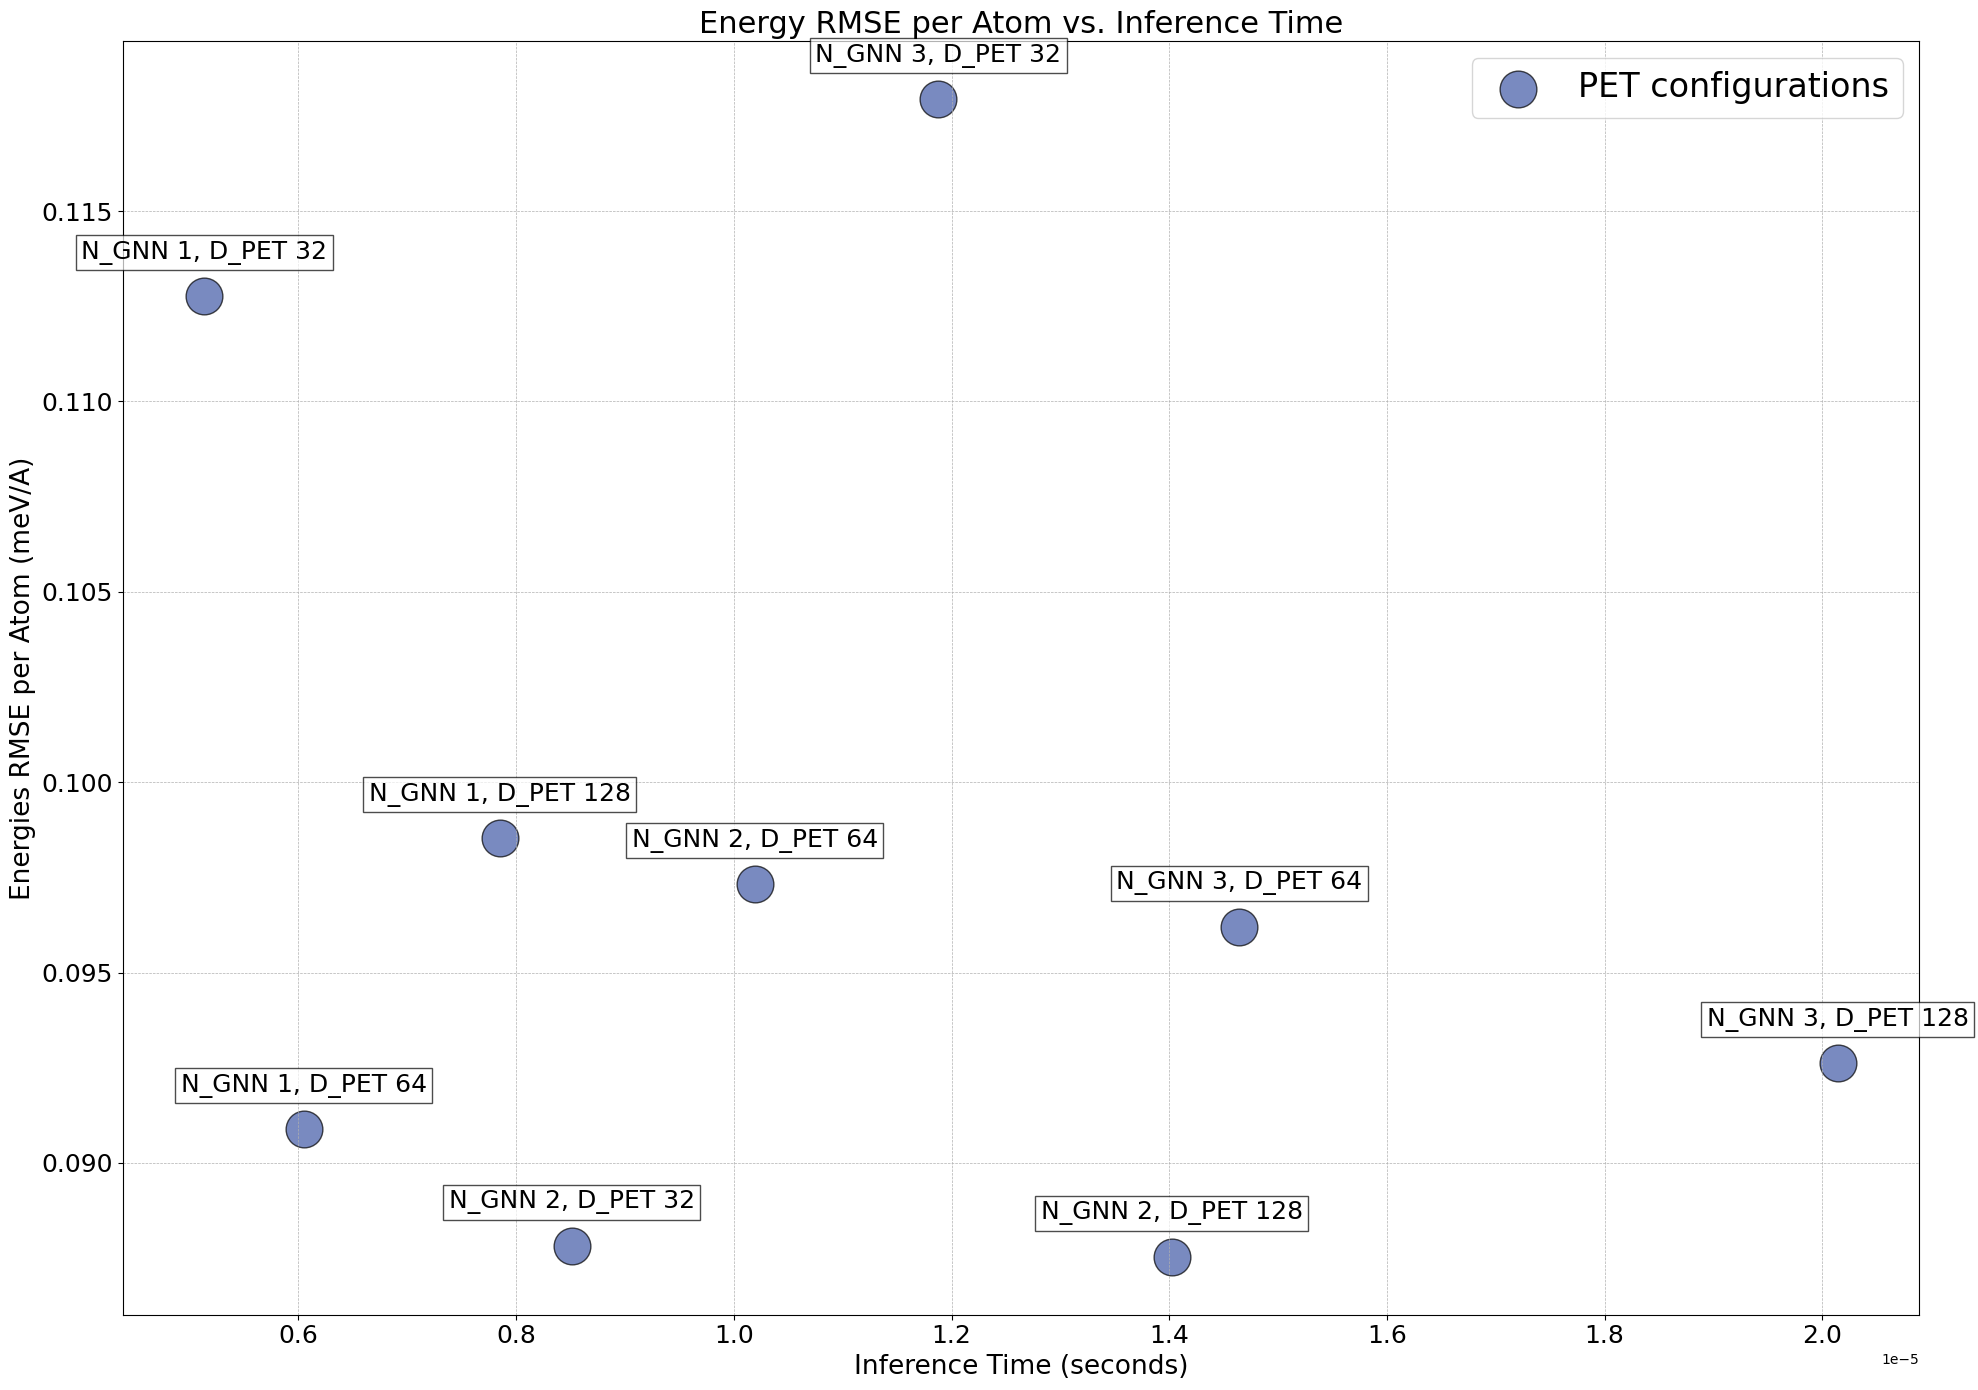

In [423]:
x_values = list(rmse_test.values())
y_values = list(interference_times.values())

plot(x_values, y_values, list(rmse_test.keys()), rmse=True)

### Test MAE vs N_GNN

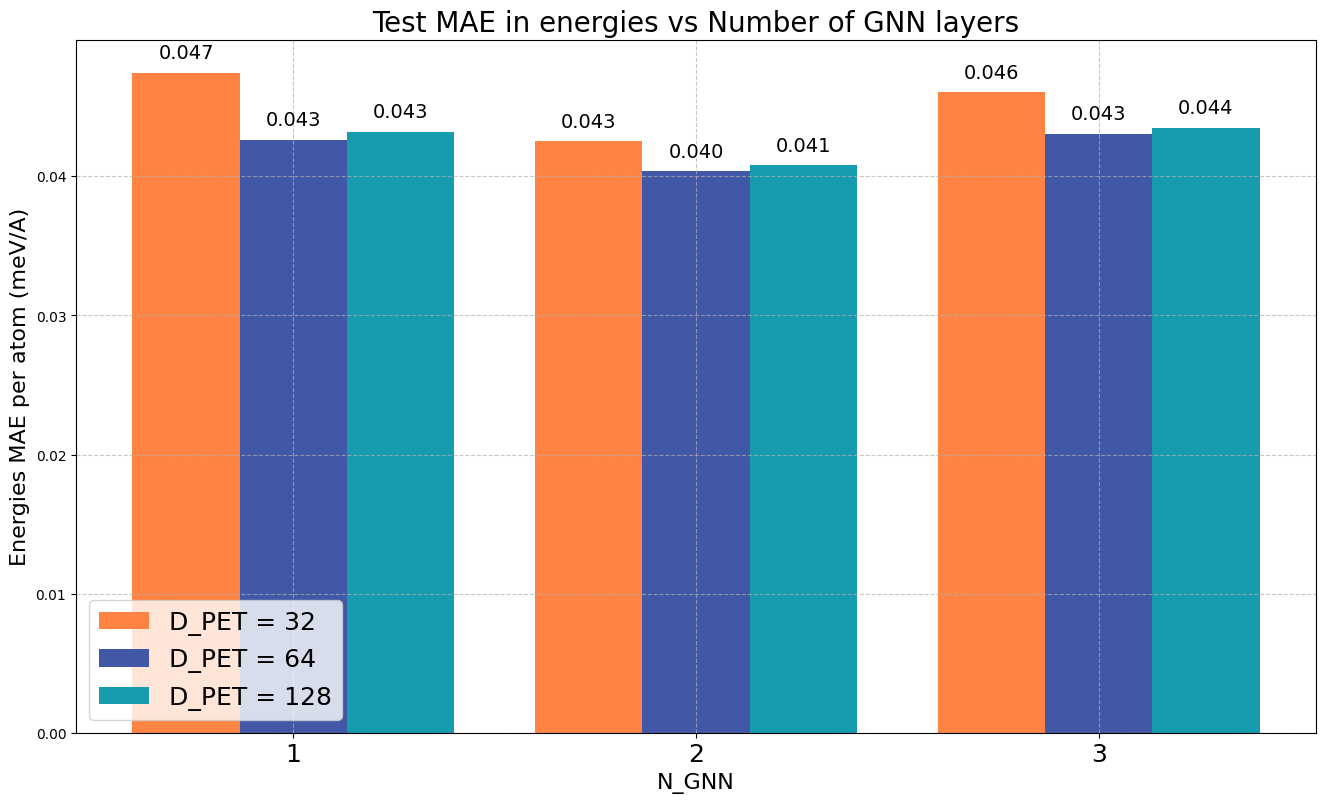

In [424]:
y_values_32 = [maes_test["N_GNN 1, D_PET 32"], maes_test["N_GNN 2, D_PET 32"], maes_test["N_GNN 3, D_PET 32"]]
y_values_64 = [maes_test["N_GNN 1, D_PET 64"], maes_test["N_GNN 2, D_PET 64"], maes_test["N_GNN 3, D_PET 64"]]
y_values_128 = [maes_test["N_GNN 1, D_PET 128"], maes_test["N_GNN 2, D_PET 128"], maes_test["N_GNN 3, D_PET 128"]]


plot_bars(
    N_GNNs,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Test MAE in energies vs Number of GNN layers",
    xlabel="N_GNN",
    ylabel="Energies MAE per atom (meV/A)",
)

### Test RMSE vs N_GNN

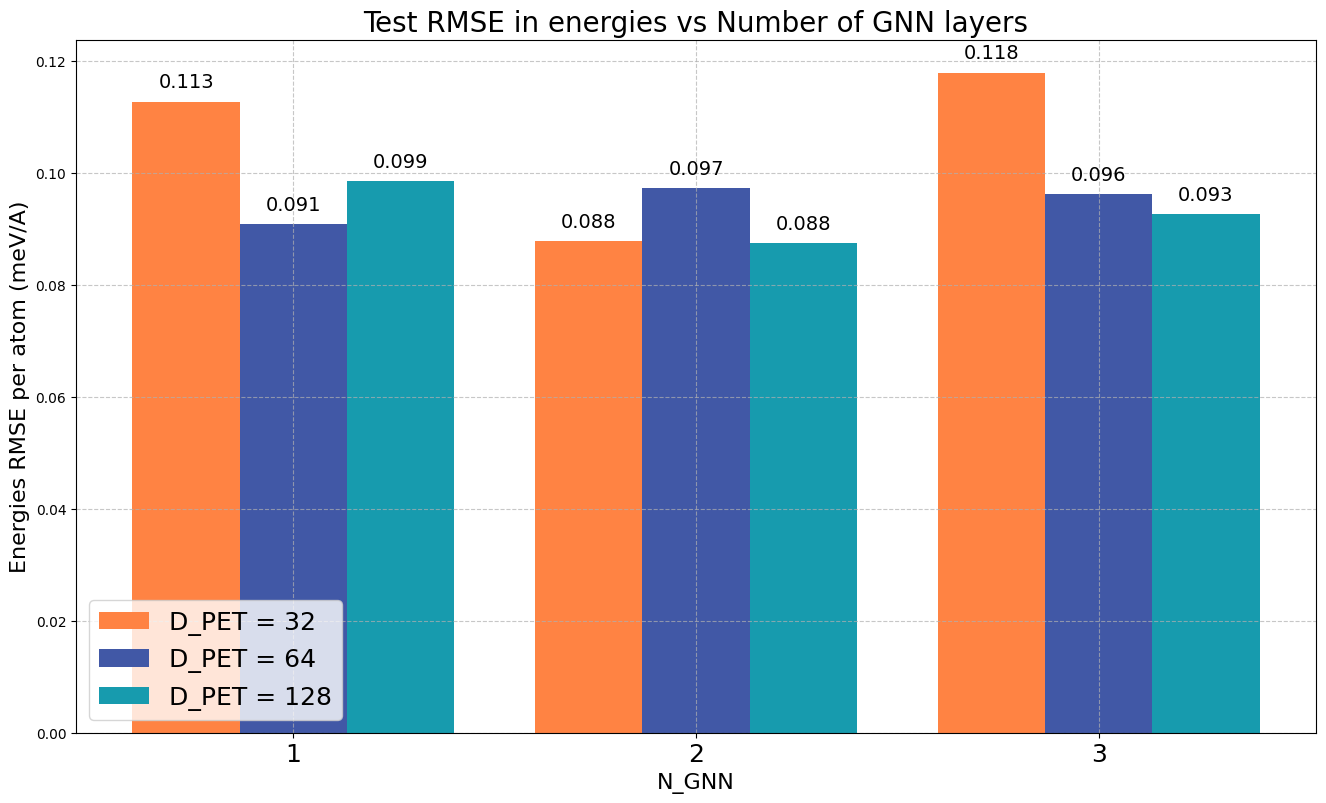

In [425]:
y_values_32 = [rmse_test["N_GNN 1, D_PET 32"], rmse_test["N_GNN 2, D_PET 32"], rmse_test["N_GNN 3, D_PET 32"]]
y_values_64 = [rmse_test["N_GNN 1, D_PET 64"], rmse_test["N_GNN 2, D_PET 64"], rmse_test["N_GNN 3, D_PET 64"]]
y_values_128 = [rmse_test["N_GNN 1, D_PET 128"], rmse_test["N_GNN 2, D_PET 128"], rmse_test["N_GNN 3, D_PET 128"]]

plot_bars(
    N_GNNs,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Test RMSE in energies vs Number of GNN layers",
    xlabel="N_GNN",
    ylabel="Energies RMSE per atom (meV/A)",
)

### Learning Rates

In [426]:
def get_smooth(values, gamma):
    smoothed = []
    for i in range(len(values)):
        if i == 0:
            smoothed.append(values[i])
        else:
            smoothed.append(gamma * values[i] + (1 - gamma) * smoothed[i - 1])
    return smoothed

In [427]:
def present(ax, files, key, energy_key="energy", rmse=True):
    ax.set_title(key, fontsize=18)
    error_key = "mae"
    if rmse:
        error_key = "rmse"

    for i, file in enumerate(files):

        # Load history.pickle
        if not os.path.exists(f"{file}/history.pickle"):
            print(f"File {file}/history.pickle does not exist.")
            continue

        with open(f"{file}/history.pickle", "rb") as f:
            data = pickle.load(f)

        # Load continuation data
        i = 0
        while os.path.isdir(f"{file}_continuation_{i}"):
            continuation_path = f"{file}_continuation_{i}/history.pickle"
            if os.path.exists(continuation_path):
                with open(continuation_path, "rb") as f:
                    continuation_data = pickle.load(f)
                data.extend(continuation_data)
                i += 1
            else:
                break

        # Get data
        grid, val_mae, train_mae = [], [], []
        for idx, el in enumerate(data):
            grid.append(idx)
            val_mae.append(el[energy_key]["val"][error_key])
            train_mae.append(el[energy_key]["train"][error_key])

        smooth_val = get_smooth(val_mae, 0.7)
        smooth_train = get_smooth(train_mae, 0.7)

        # Statistics
        print()
        print(file)
        print("val min: ", np.min(val_mae))
        print("smooth val min: ", np.min(smooth_val))
        print("val last 500: ", np.mean(val_mae[-500:]))
        print("best val pos: ", np.argmin(val_mae) / len(val_mae))
        print("train min: ", np.min(train_mae))
        print("smooth train min: ", np.min(smooth_train))

        # Plots
        ax.plot(grid, smooth_val, label=f"val {np.min(val_mae):.2e}", color="#4158A6")
        ax.plot(grid, smooth_train, label=f"train {smooth_train[-1]:.2e}", color="#FF8343")

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(fontsize=14)
    ax.grid(True)



./run_1_32/results/test
val min:  1.610045369478751
smooth val min:  1.6209593270781422
val last 500:  1.6936586671751153
best val pos:  0.5126289576663109
train min:  0.12626738449674704
smooth train min:  0.1280685568256748

./run_1_64/results/test
val min:  1.57952636654364
smooth val min:  1.61194328979367
val last 500:  1.8754848899720549
best val pos:  0.19128919860627178
train min:  0.08380317518923194
smooth train min:  0.0851863073295841

./run_1_128/results/test
val min:  1.6187659902099045
smooth val min:  1.6335382925384707
val last 500:  1.9693089644453385
best val pos:  0.2777129521586931
train min:  0.07024337299170512
smooth train min:  0.07160928976030219

./run_2_32/results/test
val min:  1.737034804217968
smooth val min:  1.785204763961006
val last 500:  1.8498348551258794
best val pos:  0.3387596899224806
train min:  0.10028850923713271
smooth train min:  0.10223090216701014

./run_2_64/results/test
val min:  1.377346584951987
smooth val min:  1.406283003600582
val

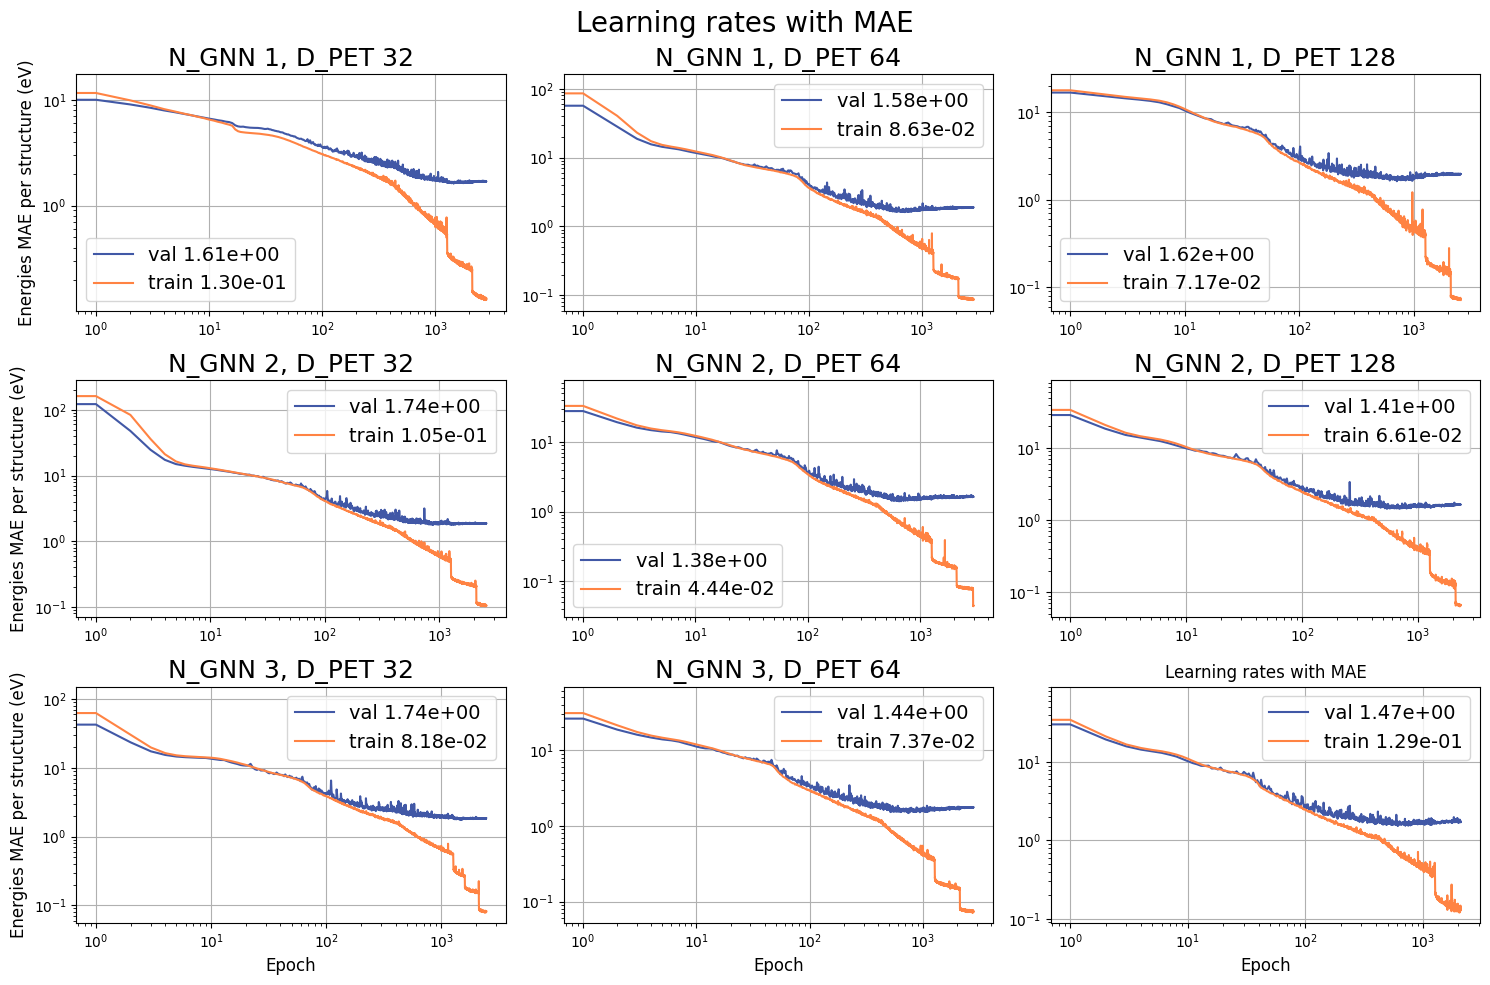

In [428]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle("Learning rates with MAE", fontsize=20)

for i, (ax, folder, key) in enumerate(zip(axes, FOLDERS, KEYS)):
    FOLDER_PATH = f"./{folder}/results/"

    files = os.listdir(FOLDER_PATH)
    files = [FOLDER_PATH + file for file in files if not file.startswith(".")]
    files = [file for file in files if "continuation" not in file]

    if i % 3 == 0:
        ax.set_ylabel("Energies MAE per structure (eV)", fontsize=12)

    if i >= 6:
        ax.set_xlabel("Epoch", fontsize=12)

    present(ax, files, key, energy_key="energies per structure")

plt.title("Learning rates with MAE")
plt.tight_layout()
plt.show()


./run_1_32/results/test
val min:  1.610045369478751
smooth val min:  1.6209593270781422
val last 500:  1.6936586671751153
best val pos:  0.5126289576663109
train min:  0.12626738449674704
smooth train min:  0.1280685568256748

./run_1_64/results/test
val min:  1.57952636654364
smooth val min:  1.61194328979367
val last 500:  1.8754848899720549
best val pos:  0.19128919860627178
train min:  0.08380317518923194
smooth train min:  0.0851863073295841

./run_1_128/results/test
val min:  1.6187659902099045
smooth val min:  1.6335382925384707
val last 500:  1.9693089644453385
best val pos:  0.2777129521586931
train min:  0.07024337299170512
smooth train min:  0.07160928976030219

./run_2_32/results/test
val min:  1.737034804217968
smooth val min:  1.785204763961006
val last 500:  1.8498348551258794
best val pos:  0.3387596899224806
train min:  0.10028850923713271
smooth train min:  0.10223090216701014

./run_2_64/results/test
val min:  1.377346584951987
smooth val min:  1.406283003600582
val

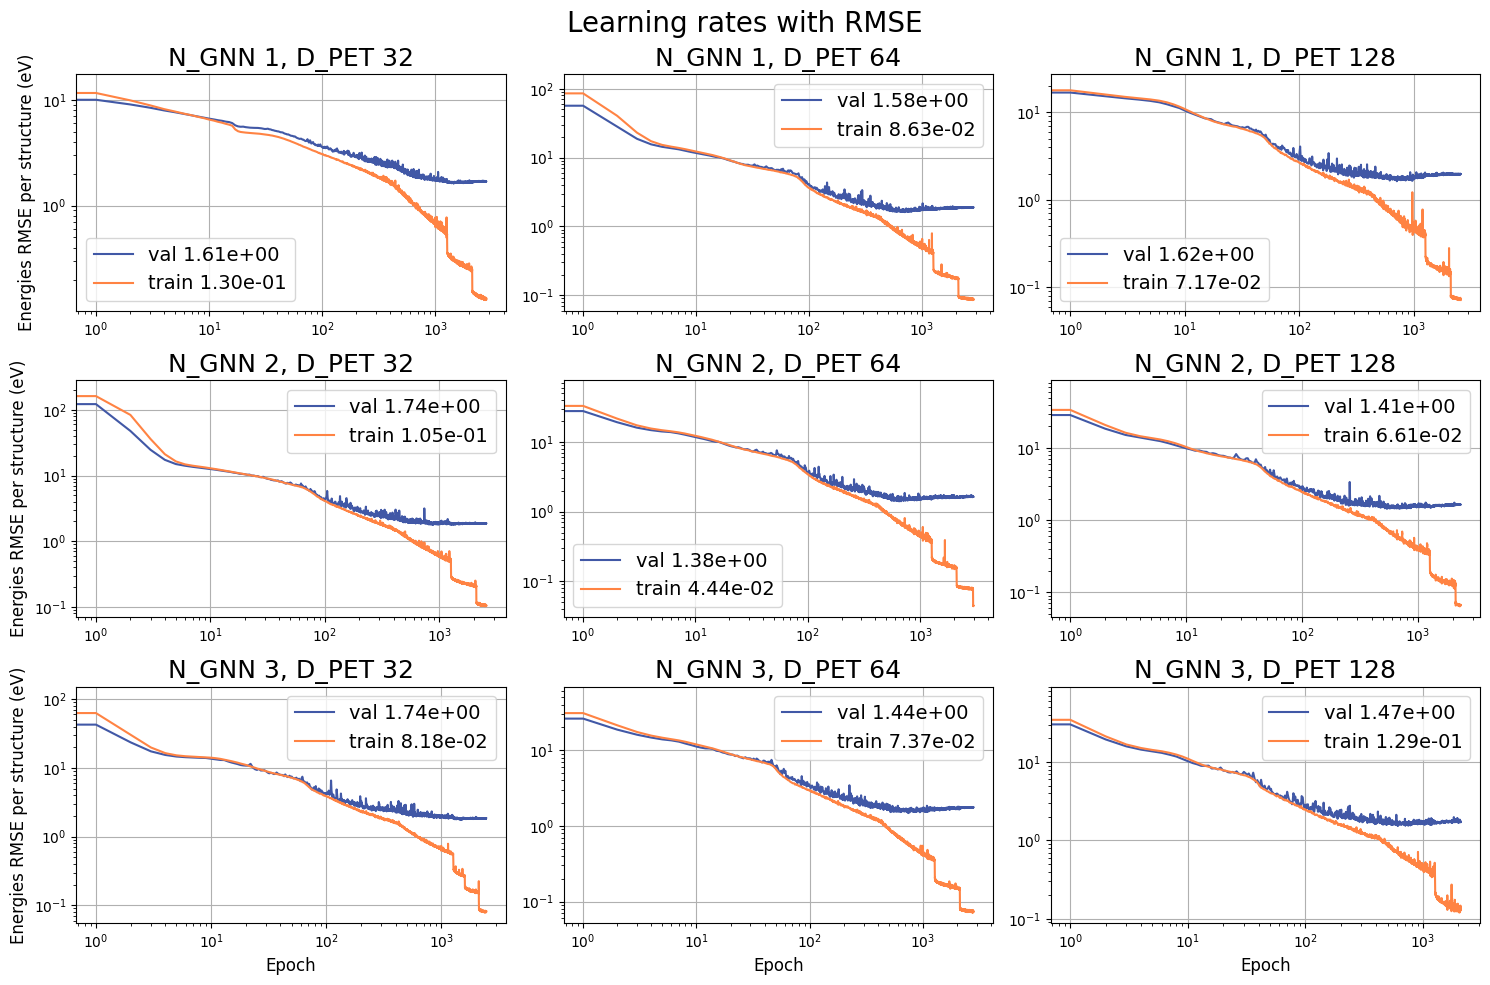

In [429]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle("Learning rates with RMSE", fontsize=20)

for i, (ax, folder, key) in enumerate(zip(axes, FOLDERS, KEYS)):
    FOLDER_PATH = f"./{folder}/results/"

    files = os.listdir(FOLDER_PATH)
    files = [FOLDER_PATH + file for file in files if not file.startswith(".")]
    files = [file for file in files if "continuation" not in file]

    if i % 3 == 0:
        ax.set_ylabel("Energies RMSE per structure (eV)", fontsize=12)

    if i >= 6:
        ax.set_xlabel("Epoch", fontsize=12)

    present(ax, files, key, energy_key="energies per structure", rmse=True)

plt.tight_layout()
plt.show()

#### Not necessary

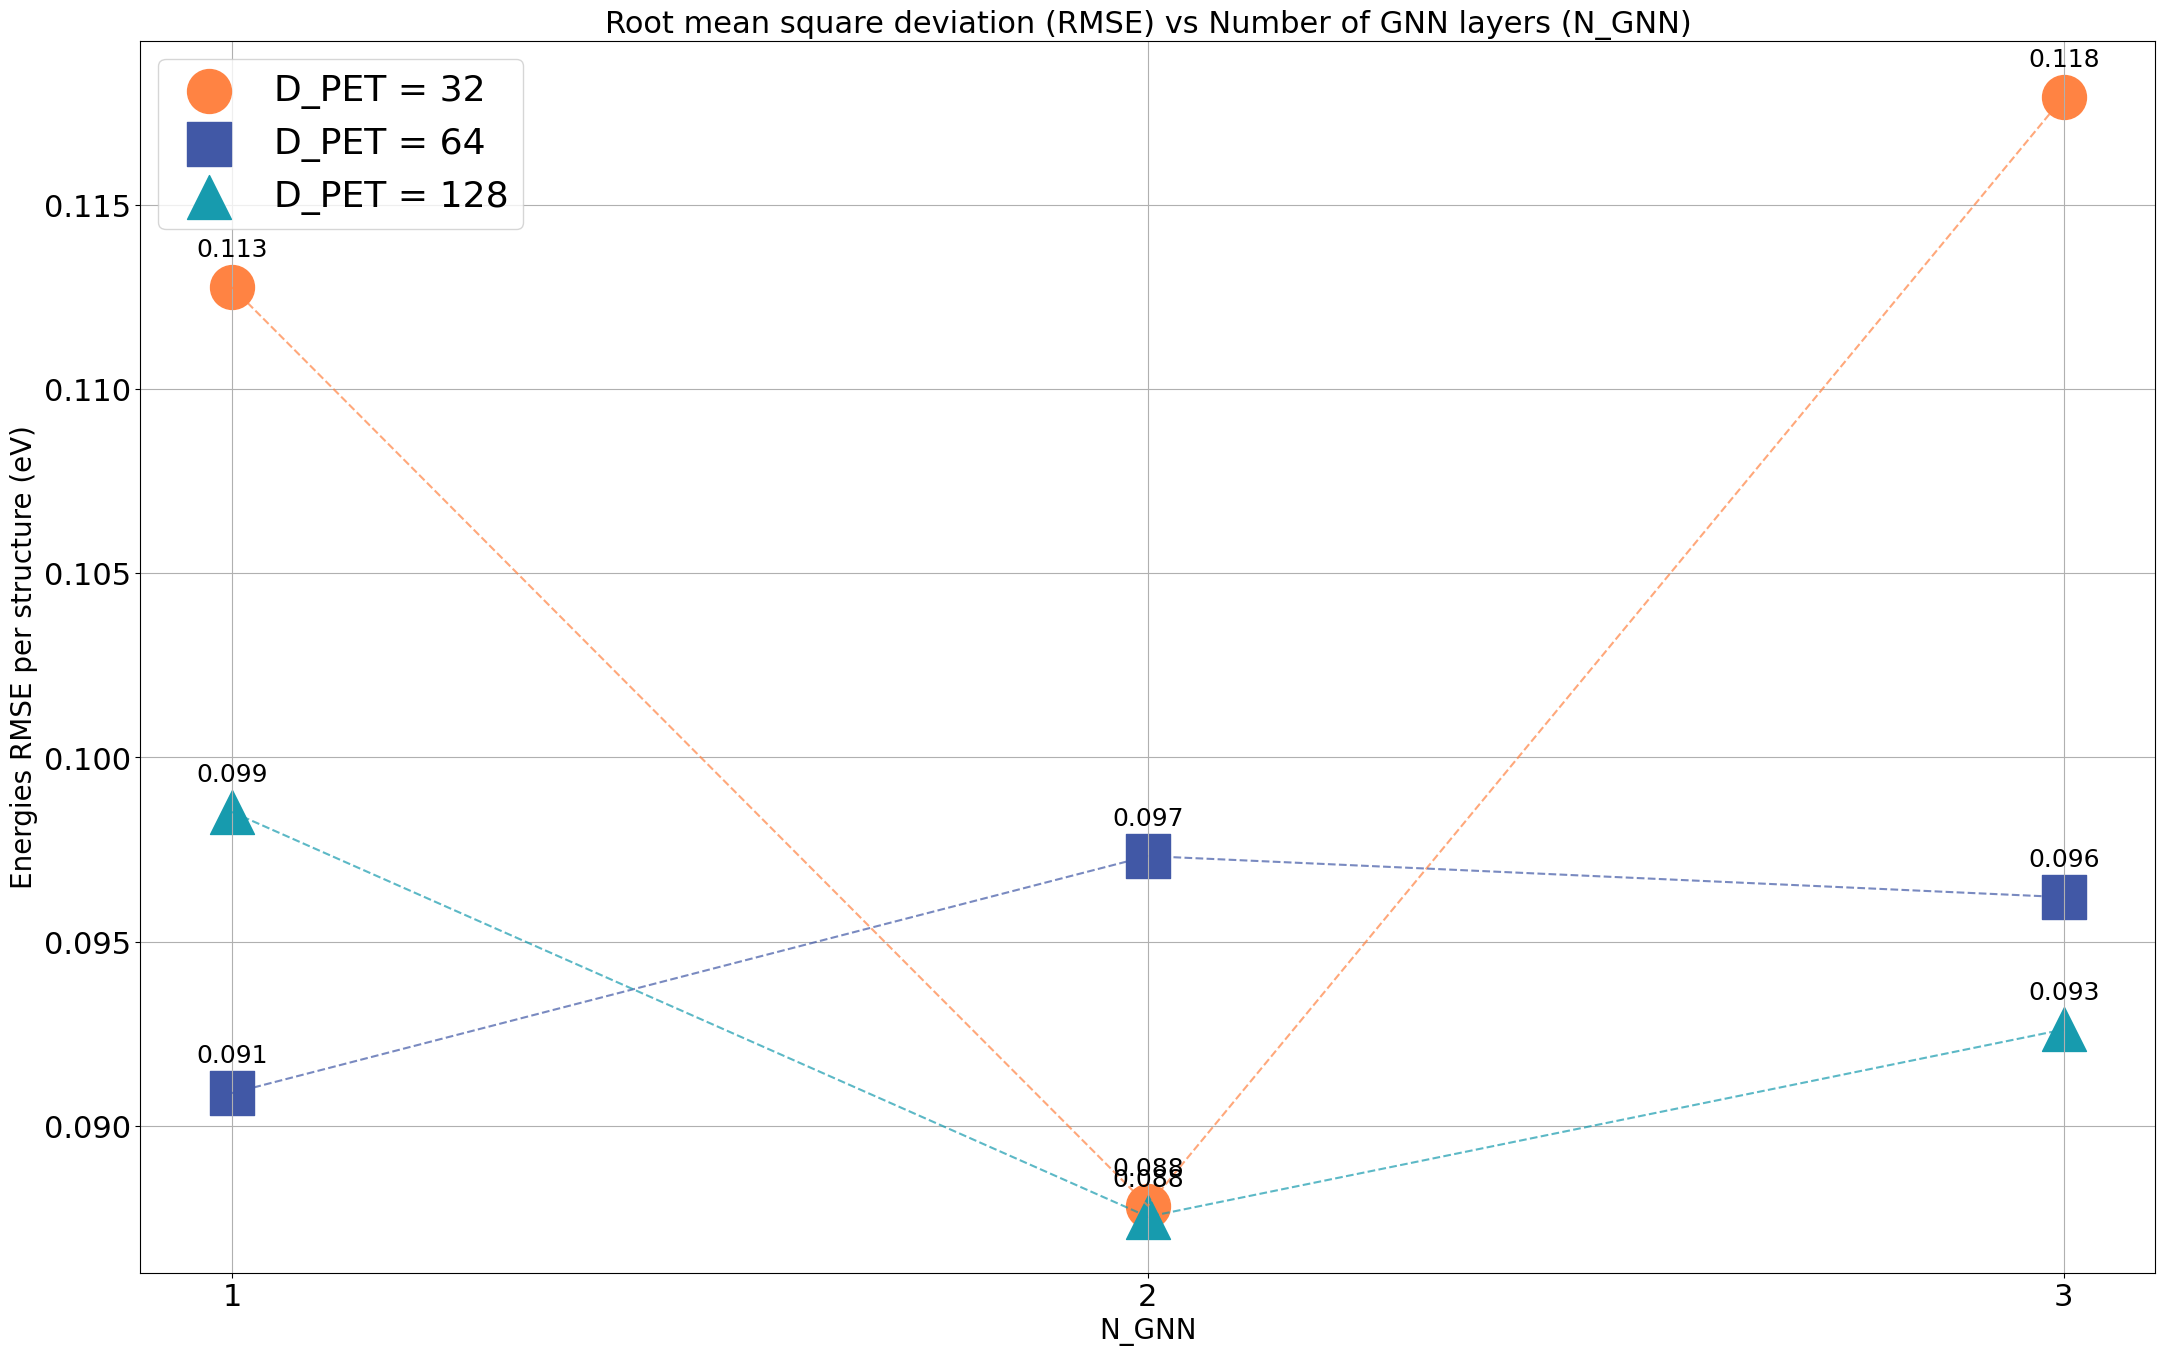

In [430]:
def plot_scatter(x_values, y_values_list, labels, title, xlabel, ylabel, colors):
    plt.figure(figsize=(26, 16))
    plt.title(title, fontsize=22)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)

    markers = ['o', 's', '^']
    for i, (y_values, label) in enumerate(zip(y_values_list, labels)):
        plt.scatter(x_values, y_values, label=label, color=colors[i], marker=markers[i], s=1000)
        plt.plot(x_values, y_values, color=colors[i], linestyle='--', alpha=0.7)

    for i, y_values in enumerate(y_values_list):
        for x, y in zip(x_values, y_values):
            plt.annotate(
                f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 22), ha="center",
                fontsize=18
            )

    plt.grid(True)
    plt.legend(fontsize=26)
    
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.show()


best_maes_32 = get_best_error(folders=folders_32, keys=N_GNNs, rmse=True)
best_maes_64 = get_best_error(folders=folders_64, keys=N_GNNs, rmse=True)
best_maes_128 = get_best_error(folders=folders_128, keys=N_GNNs, rmse=True)

x_values = list(best_maes_32.keys())
y_values_32 = list(best_maes_32.values())
y_values_64 = list(best_maes_64.values())
y_values_128 = list(best_maes_128.values())

plot_scatter(
    x_values,
    [y_values_32, y_values_64, y_values_128],
    ['D_PET = 32', 'D_PET = 64', 'D_PET = 128'],
    title="Root mean square deviation (RMSE) vs Number of GNN layers (N_GNN)",
    xlabel="N_GNN",
    ylabel="Energies RMSE per structure (eV)",
    colors=colors
)